<a href="https://colab.research.google.com/github/R-onie/Ecommerce_product_recommendation_system/blob/main/Ecommerce_product_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

import time


In [ ]:
df = pd.read_csv('ratings_Beauty.csv')
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [ ]:
df.shape

(2023070, 4)

In [ ]:
unique_userId = df['UserId'].nunique()
unique_productId = df['ProductId'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  1210271
Total number of unique Products :  249274


In [ ]:
df.isnull().sum()

,0
UserId,0
ProductId,0
Rating,0
Timestamp,0


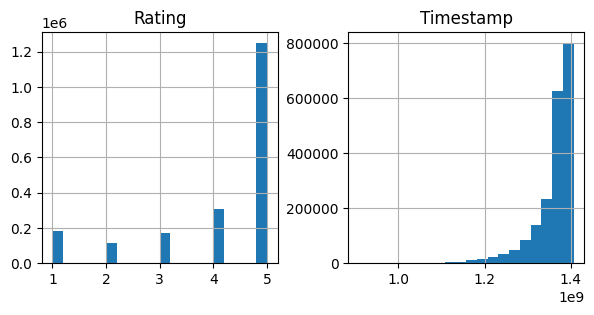

In [ ]:
# Plotting histogram
df.hist(figsize=(7,3), bins=20)
plt.show()

In [ ]:
df['Rating'].value_counts()

,count
Rating,
5.0,1248721
4.0,307740
1.0,183784
3.0,169791
2.0,113034


<Axes: >

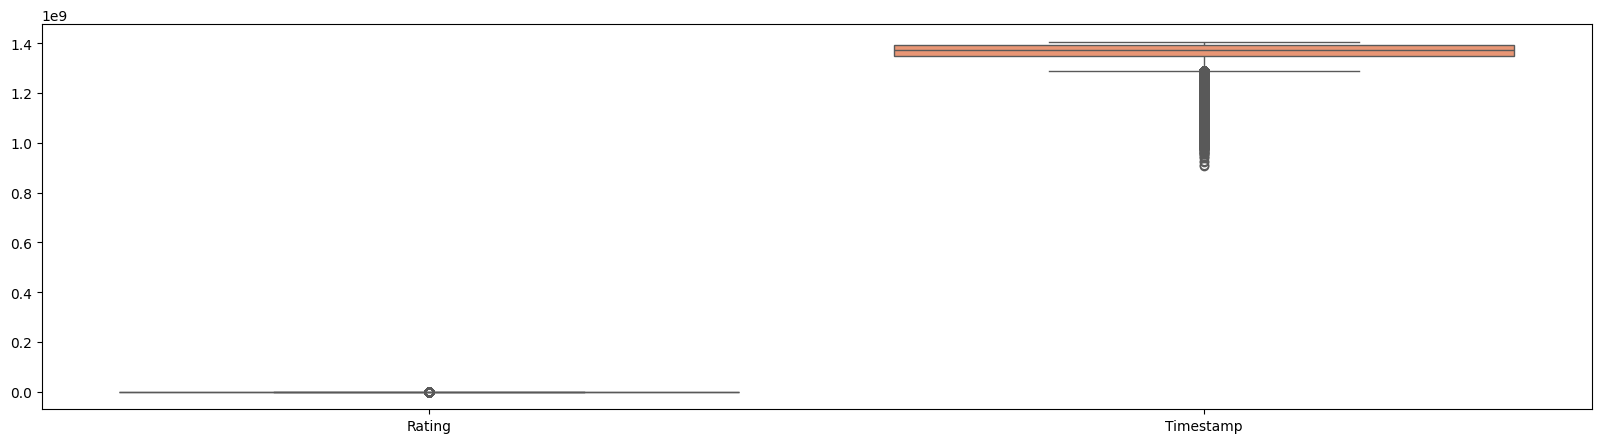

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='v', palette='Set2', dodge=False)


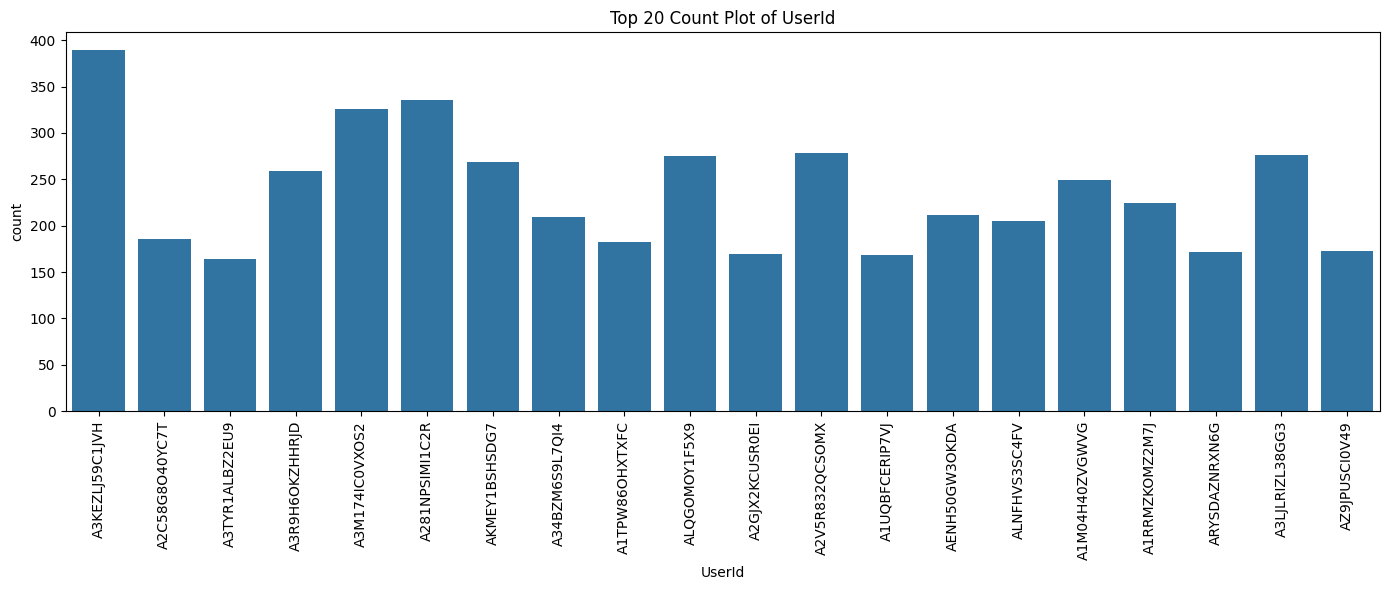

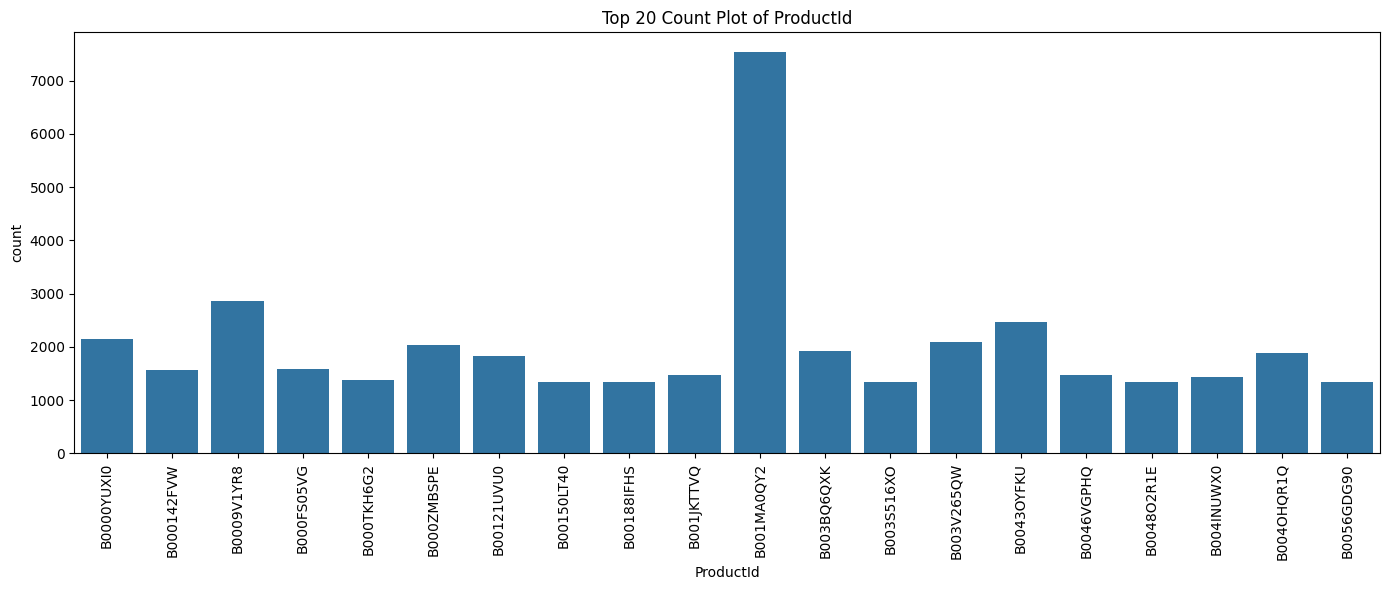

In [ ]:


# Get the top 20 UserIds by frequency
top_user_ids = df['UserId'].value_counts().head(20).index
df_top_users = df[df['UserId'].isin(top_user_ids)]

# Get the top 20 ProductIds by frequency
top_product_ids = df['ProductId'].value_counts().head(20).index
df_top_products = df[df['ProductId'].isin(top_product_ids)]

# Create count plot for top 20 UserIds
plt.figure(figsize=(14, 6))
sns.countplot(x='UserId', data=df_top_users)
plt.title('Top 20 Count Plot of UserId')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid label overlap
plt.show()

# Create count plot for top 20 ProductIds
plt.figure(figsize=(14, 6))
sns.countplot(x='ProductId', data=df_top_products)
plt.title('Top 20 Count Plot of ProductId')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid label overlap
plt.show()


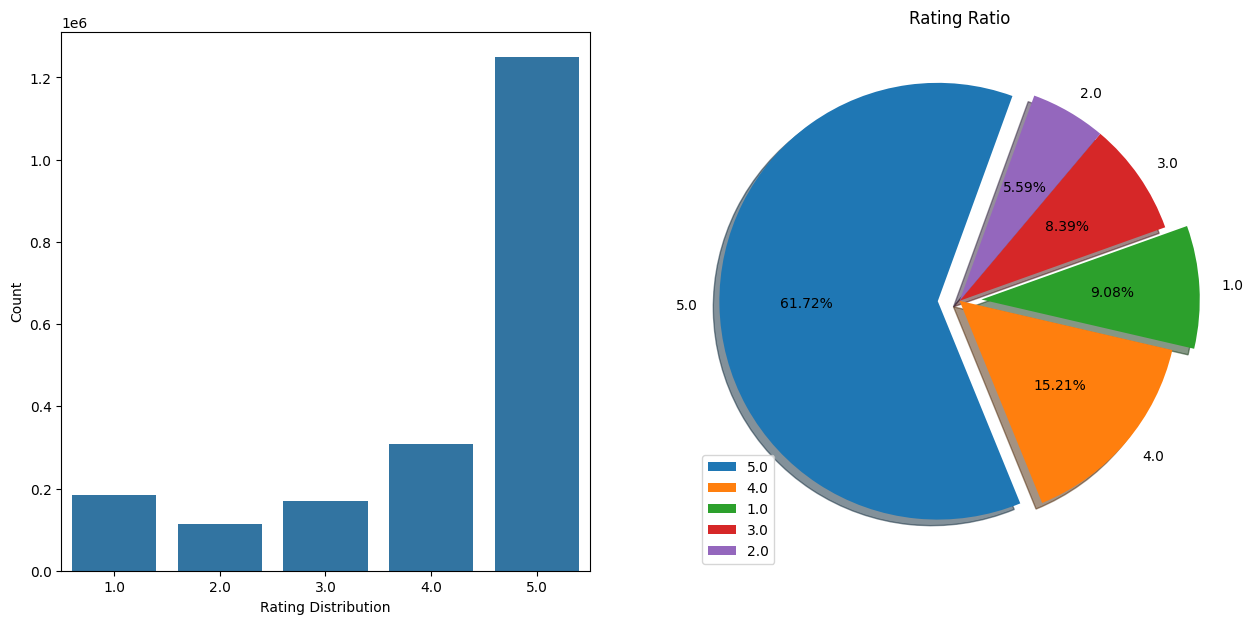

In [ ]:

# Assuming df is your dataframe
rating_counts = pd.DataFrame(df['Rating'].value_counts()).reset_index()
rating_counts.columns = ['Rating', 'Count']  # Rename columns for clarity

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Count plot for Rating distribution
sns.countplot(x='Rating', data=df, ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

# Pie chart for Rating ratio
explode = (0.1, 0, 0.1, 0, 0)  # explode parameter to highlight certain slices
ax2.pie(rating_counts['Count'], explode=explode, labels=rating_counts['Rating'], autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Rating Ratio")
plt.legend(rating_counts['Rating'], loc=3)

# Show the plot
plt.show()


In [ ]:
df = df.drop(['Timestamp'], axis=1)

In [ ]:
df1 = df.copy()

In [ ]:
df1['UserId'].value_counts()

,count
UserId,
A3KEZLJ59C1JVH,389
A281NPSIMI1C2R,336
A3M174IC0VXOS2,326
A2V5R832QCSOMX,278
A3LJLRIZL38GG3,276
...,...
AFLE9ZCCERY6L,1
A2U2AW7L2BU1S,1
A2KNQZY2DU4H8I,1


Taking a subset of the dataset to make it less sparse/ denser.( For example, keep the users only who has given 50 or more number of ratings )


In [ ]:
users_counts = df1['UserId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),
                                left_on='UserId',
                                right_index=True)

In [ ]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,UserId,ProductId,Rating,users_counts
5,AKJHHD5VEH7VG,0762451459,5.0,90
42,A22ZFXQE8AWPEP,1304482596,1.0,63
47,A22ZFXQE8AWPEP,1304482685,1.0,63
52,A22ZFXQE8AWPEP,1304495396,1.0,63
61,A22ZFXQE8AWPEP,1304511111,1.0,63


In [ ]:
product_rating_counts = subset_df['ProductId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='ProductId',
                                right_index=True)

product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,UserId,ProductId,Rating,users_counts,product_rating_counts
36954,A2S7YBFPZX1IGQ,B0000CC64W,2.0,65,12
37076,A3U5RYD678A4LL,B0000CC64W,5.0,54,12
37077,A1X2LENOF84LCQ,B0000CC64W,4.0,55,12
37126,A2PATWWZAXHQYA,B0000CC64W,1.0,57,12
37162,A3IOCPLIMYDBCD,B0000CC64W,5.0,77,12


In [ ]:
amazon_df = product_rating_data.copy()

In [ ]:
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)

In [ ]:
panda_data.head()

,UserId,ProductId,Rating
36954,A2S7YBFPZX1IGQ,B0000CC64W,2.0
37076,A3U5RYD678A4LL,B0000CC64W,5.0
37077,A1X2LENOF84LCQ,B0000CC64W,4.0
37126,A2PATWWZAXHQYA,B0000CC64W,1.0
37162,A3IOCPLIMYDBCD,B0000CC64W,5.0


In [ ]:
panda_data.shape

(5905, 3)

# Spliting the data randomly into train and test dataset. (Split it in 70/30 ratio)

In [ ]:
k = 5

In [ ]:
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(panda_data[['UserId', 'ProductId', 'Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

Building Collaborative Filtering model

Collaborative Filtering is a popular technique used in recommendation systems, where the system makes predictions about a user's interests by collecting preferences or ratings from many users

Example: If User A and User B both liked movies X and Y, and User A also liked movie Z, the system might recommend movie Z to User B, assuming they will also like it

For the Collaborative Filtering Model I am going to use SVD, KNNWithZscore and I will also test with other algorithm

Matrix Factorization Based Algorithms

Here I am Using grid search to find out the best hyper parameters for SVD and SVDpp Algorithm.

n_epochs values : [20, 25]
lr_all : [0.007, 0.009, 0.01]
reg_all : [0.4, 0.6]

In [ ]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.9078353111847596
0.9055198667675631
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}


In [ ]:
cv_results = []  # to store cross validation result

In [ ]:
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'],
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8911  0.9373  0.8941  0.9165  0.9040  0.9086  0.0169  
MAE (testset)     0.6931  0.7237  0.6936  0.7068  0.7069  0.7048  0.0112  
Fit time          0.06    0.06    0.06    0.06    0.06    0.06    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8846

 Computational Time : 0.433s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.908623,0.704827,0.057062,0.006334


SVDpp

In [ ]:
start_time = time.time()

# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)


# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'],
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = pd.concat([cv_results, svdpp_cv_results], ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8587  0.9275  0.9283  0.9218  0.8973  0.9067  0.0265  
MAE (testset)     0.6691  0.7111  0.7210  0.7089  0.6998  0.7020  0.0178  
Fit time          0.48    0.48    0.45    0.46    0.47    0.47    0.01    
Test time         0.09    0.06    0.10    0.10    0.05    0.08    0.02    


==================== Model Evaluation ===============================
RMSE: 0.8866

 Computational Time : 3.284s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.908623,0.704827,0.057062,0.006334
1,SVDpp,0.906693,0.701971,0.467306,0.079904


 k-NN Based Algorithms

In [ ]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

0.9674909403342984
0.9427957150679968
0.9325214116970247
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 25, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}}

Computational Time : 70.613s


In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = pd.concat([cv_results,knnBasic_cv_results], ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9807  0.9466  0.9748  0.9877  0.9521  0.9684  0.0161  
MAE (testset)     0.7530  0.7358  0.7385  0.7513  0.7296  0.7417  0.0091  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.05    0.06    0.06    0.06    0.06    0.06    0.00    


==================== Model Evaluation ===============================
RMSE: 0.9442

 Computational Time : 0.

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.908623,0.704827,0.057062,0.006334
1,SVDpp,0.906693,0.701971,0.467306,0.079904
2,KNNBasic,0.968382,0.741656,0.006203,0.057679


In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'],
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = pd.concat([cv_results,knnZscore_cv_results], ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9097  0.9369  0.9805  0.9150  0.9138  0.9312  0.0264  
MAE (testset)     0.6984  0.7008  0.7414  0.6970  0.6885  0.7052  0.0185  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.07    0.07    0.08    0.07    0.07    0.07    0.00    


==================== Model Evaluation ===============================
RMSE: 0.9259

 Computational Time

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.908623,0.704827,0.057062,0.006334
1,SVDpp,0.906693,0.701971,0.467306,0.079904
2,KNNBasic,0.968382,0.741656,0.006203,0.057679
3,KNNWithZScore,0.931170,0.705223,0.019733,0.070865


In [ ]:
# User Input for Product Recommendation
user_id = input("Enter User ID: ")  # User ID input
top_n = int(input("How many top products would you like to recommend? "))  # Number of recommendations

# Get a list of all product IDs in your dataset
all_product_ids = df1['ProductId'].unique()

# Predict ratings for all products for the given user
predictions = [svd_model.predict(user_id, product_id) for product_id in all_product_ids]

# Sort predictions by predicted ratings in descending order
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

# Display top N recommended products
print(f"\nTop {top_n} product recommendations for User {user_id}:")
for i in range(top_n):
    print(f"Product ID: {sorted_predictions[i].iid}, Predicted Rating: {sorted_predictions[i].est:.2f}")

# Show cross-validation results
#print(cv_results)

Enter User ID: u
How many top products would you like to recommend? 4

Top 4 product recommendations for User u:
Product ID: B004GIM68G, Predicted Rating: 4.63
Product ID: B00IP42FBA, Predicted Rating: 4.62
Product ID: B00DCNBST4, Predicted Rating: 4.60
Product ID: B004Z209HS, Predicted Rating: 4.56


Disadvantages of Collaborative Filtering:
Cold Start Problem:

For new users or items with no ratings or limited data, the system struggles to make recommendations because there is not enough data to find similar users or items.
Sparsity:

In large datasets with many items, most users will only rate a small fraction of the items, leading to sparse data and making it difficult to find meaningful similarities.
Scalability:

As the number of users and items grows, the computational cost of finding similar users or items increases, which can make it challenging to scale.
Popularity Bias:

Collaborative filtering often tends to recommend popular items, as they have been rated by many users, potentially missing out on niche or less popular items that might be interesting to the user.

Key Points:
Input (Features): In your recommendation system, the inputs are typically the UserId and ProductId. These are the features that help the model make predictions.

Target (What the model predicts): The target in your case is the rating that the user gives to a product. The model is trained to predict the rating a user would give to a product they haven't rated yet. This is a regression problem, as the model predicts a continuous value (the rating).

Goal of the Recommendation: The goal is to recommend products that the user is likely to rate highly. This is achieved by predicting the ratings for all products and then recommending those with the highest predicted ratings.